## Segmentation Cleanup V3 (normalized data, gold filter > 10)
This notebook was created for users looking to clean up and ehance the outputs from DeepCell/Notebook1.\
\
This notebook contains the following:
1. Data visualization. This is intended to make it easier to set filters for your data to select certain cells.
2. Cell expansion. To be used in cases where only the nucleus of cells are being captured even with membrane markers. Options include by set pixel radius or percent per cell.
3. Split large nuclei. From the segmentation utils function to split cells where nuclei are merged.
4. Cell removal. Removal of artifact left over from segmentation such as mixed signal or cells with extremely low size.
5. Creat new cell table.

xxxxxxx_Work in progress_xxxxxxx \
- One thing that i really need to add in here is an option to link and use the nuclear mask.\
- At the end of the day what even is the nuclear mask? It's honestly never used unless you want it for a hyper specific reason.


In [1]:
#import packages
import os
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import skimage.io as io
import math

from alpineer import io_utils
from ark.utils import plot_utils
from scipy.ndimage import grey_dilation
from ark.segmentation import marker_quantification
from ark.utils import (data_utils, deepcell_service_utils, example_dataset,
                       plot_utils, segmentation_utils)
import shutil

## 0. Set Paths
The path structure should pull from the segmentation mask you wish to edit. Once edited, this new segmentation mask and cell table should be saved to a new output folder, afterwards it can be edited with cell removal.

In [2]:
#setworking directory
os.getcwd()

'/c4/home/brford/HNSCC/HNLN'

In [3]:
os.chdir('/c4/home/brford/HNSCC/HNLN/')
os.getcwd()

'/c4/home/brford/HNSCC/HNLN'

In [4]:
#set base directory
base_dir = './'

#set paths for raw segmentation output
tiff_dir = os.path.join(base_dir, "raw_data/")
tiff_dir_au = os.path.join(base_dir, "segmentation_norm/rawGoldTIFFs")
deepcell_input_dir = os.path.join(base_dir, "segmentation_norm/deepcell_input")
deepcell_output_dir = os.path.join(base_dir, "segmentation_norm/deepcell_output")
cell_table = os.path.join(base_dir, "segmentation_norm/cell_table_expanded/cell_table_arcsinh_transformed_expanded.csv")
df = pd.read_csv(cell_table)

#set paths for new expanded output
#expansion_deepcell_output_dir = os.path.join(base_dir, "segmentation_v1/deepcell_output_expanded")
#expansion_cell_table_dir = os.path.join(base_dir, "segmentation_v1/cell_table_expanded/")
#expansion_deepcell_visualization_dir =os.path.join(base_dir, "segmentation_v1/deepcell_output_viz")

#idk if something needs to be done for the split nuclei... we'll see later.

#set paths for final cell removal output
clean_deepcell_output_dir = os.path.join(base_dir, "segmentation_norm/deepcell_output_cell_rem_highGold")
clean_cell_table_dir = os.path.join(base_dir, "segmentation_norm/cell_table_cell_rem_highGold/")
clean_deepcell_visualization_dir =os.path.join(base_dir, "segmentation_norm/deepcell_output_viz_highGold/")

fovs = io_utils.list_folders(tiff_dir)
print(fovs)

['2022-03-09T08-59-38-fov-1-scan-1', '2022-03-17T13-45-35-fov-2-scan-1', '2022-03-21T22-45-42-fov-4-scan-1', '2022-03-18T16-29-36-fov-5-scan-1', '2022-03-21T11-08-40-fov-1-scan-1', '2022-03-06T22-21-28-fov-2-scan-1', '2022-03-20T21-27-57-fov-7-scan-1', '2022-03-05T13-06-28-fov-5-scan-1', '2022-03-09T08-59-38-fov-4-scan-1', '2022-03-08T17-49-24-fov-2-scan-1']


In [5]:
# create directories if do not exist
for directory in [clean_deepcell_output_dir, clean_cell_table_dir, clean_deepcell_visualization_dir ]:
    if not os.path.exists(directory):
        os.makedirs(directory)

In [6]:
#set the fov's you wish to work with. If you want to use all fov's in the folder set fov_vis = fovs
fov_vis = fovs

## 4. Cell Removal
Finally, use this notebook to take out any cells suspected of being artifact or called due to messy signal.
\
\
Again the results can be visualized at the bottom to ensure the proper cells were removed.

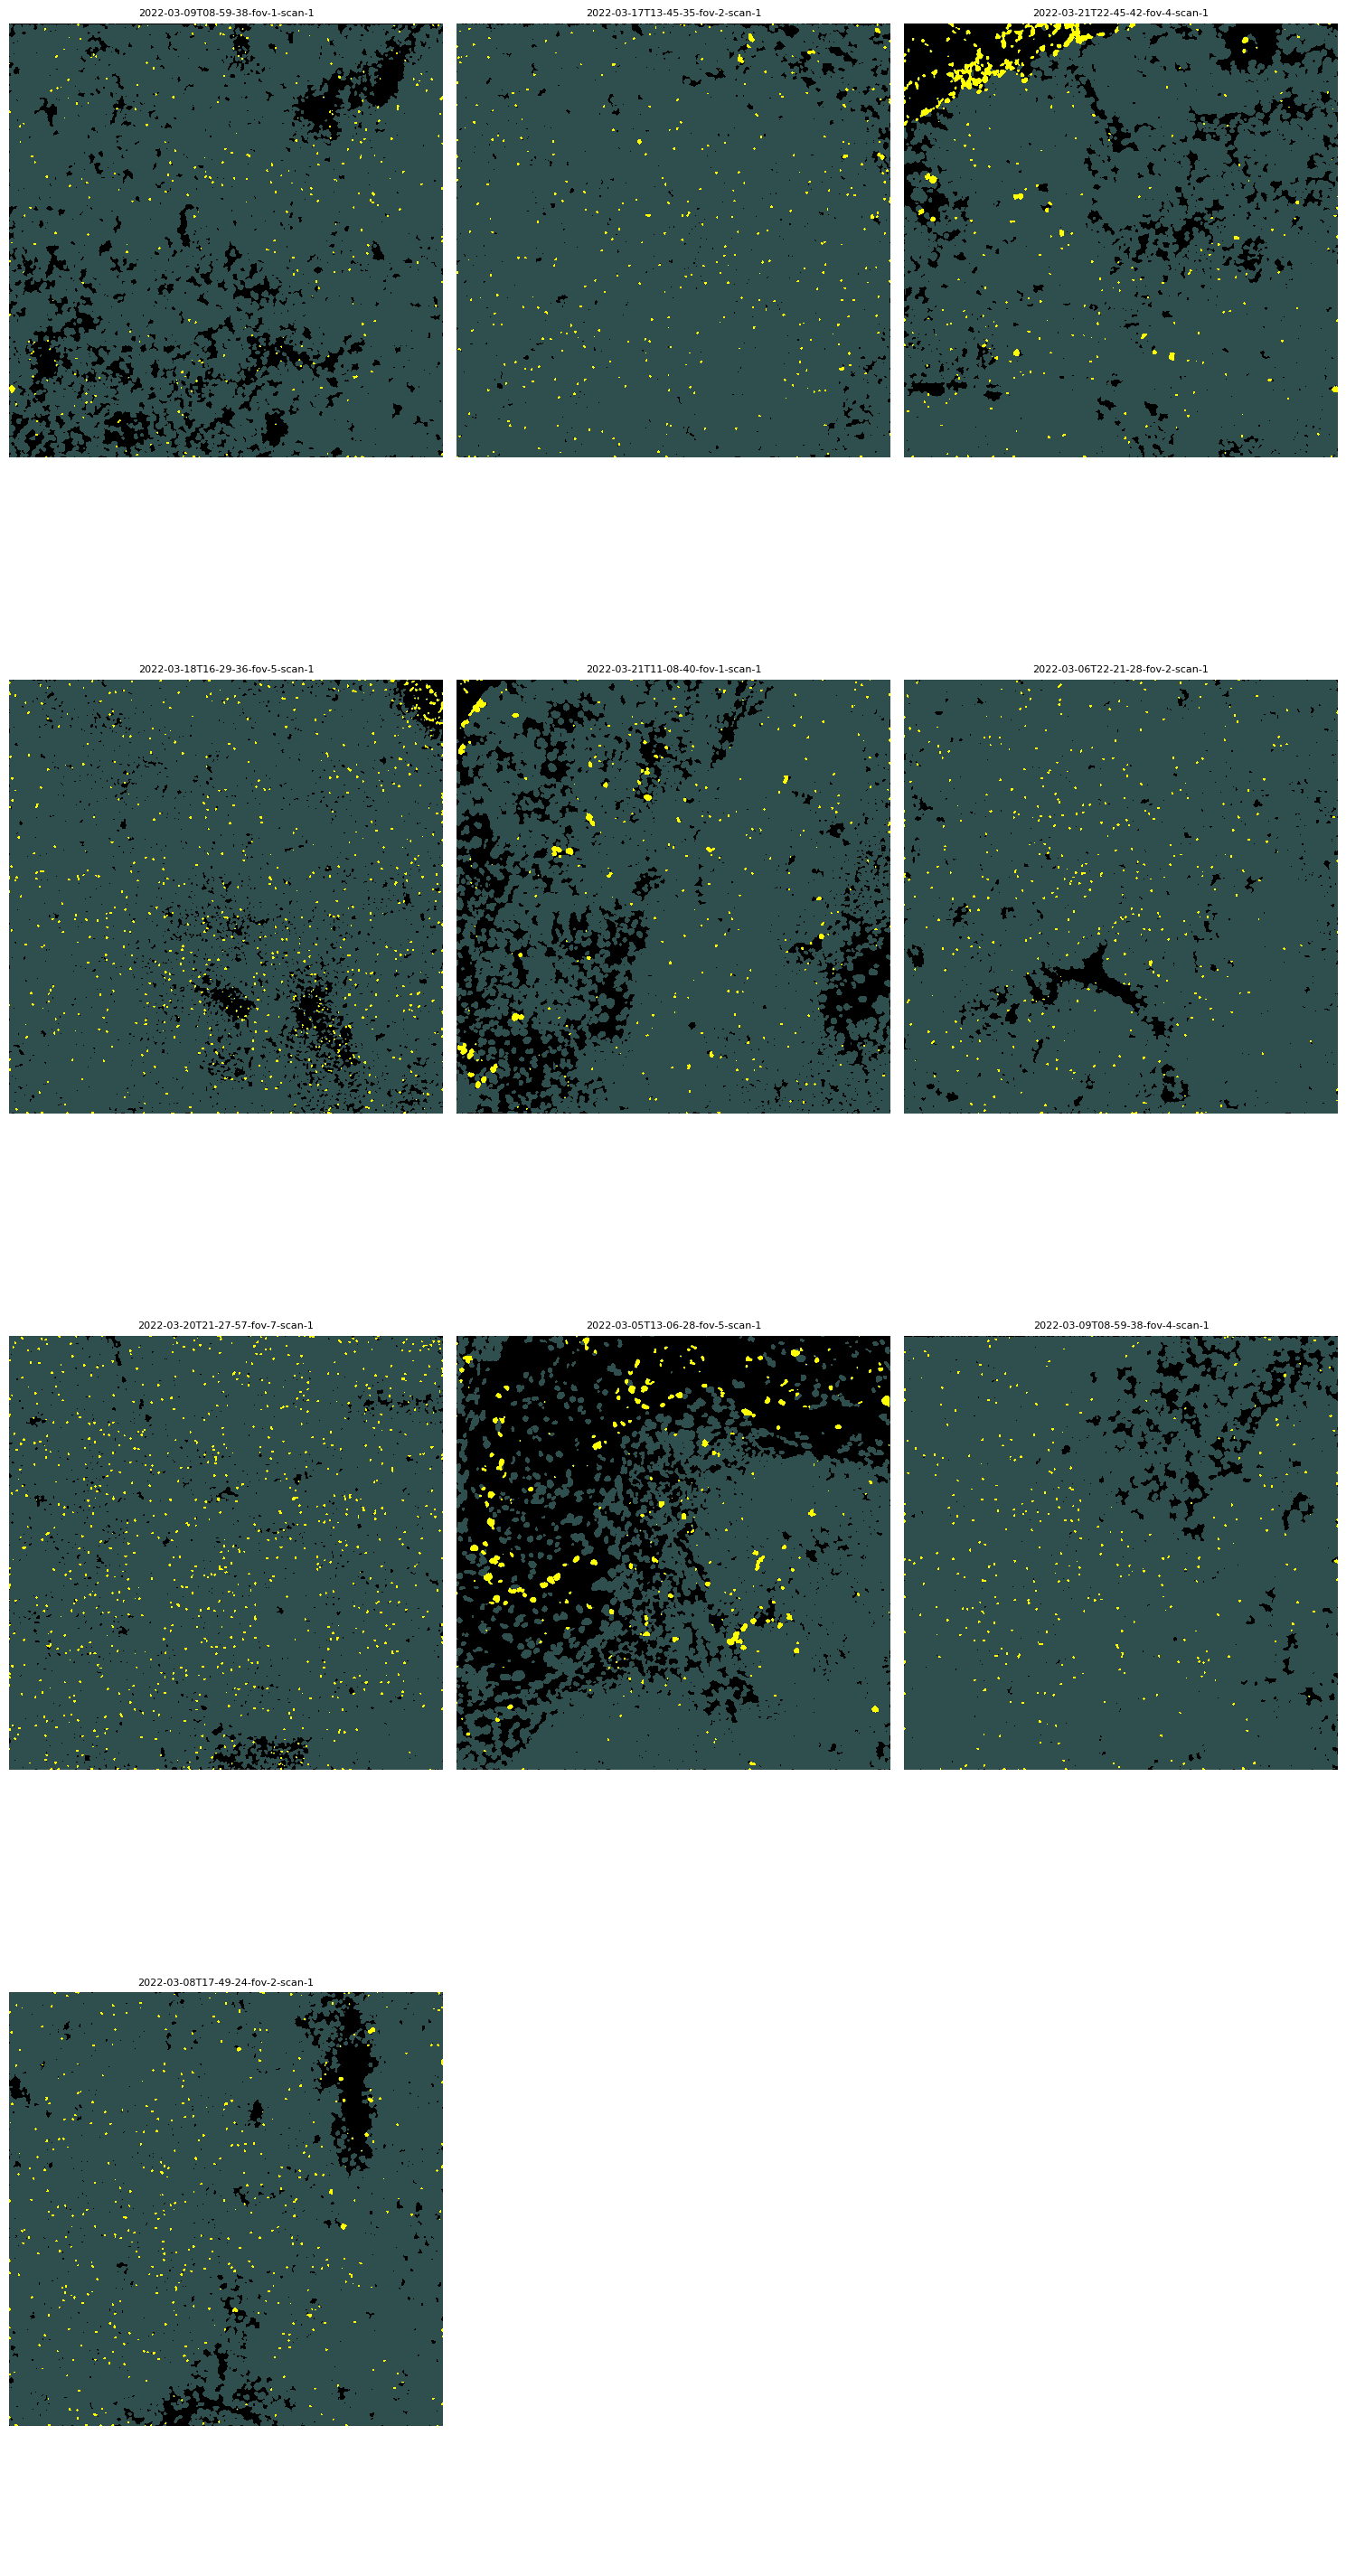

In [7]:
# Set the number of columns for the subplot grid
num_columns = 3
num_rows = (len(fov_vis) + num_columns - 1) // num_columns
fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 30))
# Flatten the axs array if it has multiple dimensions
if axs.ndim > 1:
    axs = axs.flatten()

for i, fov in enumerate(fov_vis):
    # Set the correct paths for everything within the for loop so it reads it in the right order.
    nuclear_mask = "_nuclear.tiff"
    cell_mask = "_whole_cell.tiff"
    nuc_seg_path = os.path.join(deepcell_output_dir, fov + nuclear_mask)
    whole_cell_seg_path = os.path.join(deepcell_output_dir, fov + cell_mask)

    # Open up the nuclear mask... doesn't actually do anything yet.
    nuc_seg_mask = np.array(Image.open(nuc_seg_path))

    # Open up the cell mask... what does work.
    whole_cell_seg_mask = np.array(Image.open(whole_cell_seg_path))
    whole_cell_seg_mask2 = np.array(Image.open(whole_cell_seg_path)) #used for visualization

    # Filter the data frame for the current fov
    filtered_df = df[df['fov'].str.contains(fov)]

    # Filter number 1 SET YOUR OWN FILTERS HERE!!!!!
    numbers_to_remove_2 = filtered_df[filtered_df['cell_size'] < 100]['label'].astype(int).tolist()
    numbers_to_keep_2 = filtered_df[~(filtered_df['cell_size'] < 100)]['label'].astype(int).tolist()

    # Filter number 2 SET YOUR OWN FILTERS HERE!!!!!
    numbers_to_remove_3 = filtered_df[filtered_df['Au'] > 10]['label'].astype(int).tolist()
    numbers_to_keep_3 = filtered_df[~(filtered_df['Au'] > 10)]['label'].astype(int).tolist()
    
    # Filter number 2 SET YOUR OWN FILTERS HERE!!!!!
    numbers_to_remove_4 = filtered_df[filtered_df['dsDNA'] < 0.2]['label'].astype(int).tolist()
    numbers_to_keep_4 = filtered_df[~(filtered_df['dsDNA'] < 0.2)]['label'].astype(int).tolist()

    # Make your new function here before adding them to the combined numbers.
    combined_numbers_to_remove = list(set(numbers_to_remove_2 + numbers_to_remove_3 + numbers_to_remove_4))
    combined_numbers_to_keep = list(set(numbers_to_keep_2 + numbers_to_keep_3 + numbers_to_remove_4))

    # Replace all values in the combined list with 0
    mask = np.isin(whole_cell_seg_mask, combined_numbers_to_remove)
    whole_cell_seg_mask[mask] = 0
    
    # Save the modified whole cell mask... doesn't do anything for nuc yet.
    image = Image.fromarray(whole_cell_seg_mask)
    save_path = os.path.join(clean_deepcell_output_dir, fov + "_whole_cell.tiff")
    image.save(save_path)

    # Copy nuclear mask files from original directory
    shutil.copy(os.path.join(deepcell_output_dir, fov + "_nuclear.tiff"), clean_deepcell_output_dir)
    
    # Visualization using the selected fov to display
    cmap = mcolors.ListedColormap(['black', 'darkslategrey', 'yellow']) # black = background, grey = untouched, yellow = cells removed
    norm = mcolors.Normalize(vmin=0, vmax=2)
    new_mask = np.zeros_like(whole_cell_seg_mask2)
    new_mask[np.isin(whole_cell_seg_mask2, combined_numbers_to_keep)] = 1
    new_mask[np.isin(whole_cell_seg_mask2, combined_numbers_to_remove)] = 2
    merged_mask = np.maximum(new_mask, new_mask)

    axs[i].imshow(merged_mask, cmap=cmap, norm=norm)
    axs[i].axis('off')
    axs[i].set_title(fov, fontsize=8)

#Hide any remaining empty subplots
for j in range(len(fov_vis), num_rows * num_columns):
               axs[j].axis('off')

plt.tight_layout()
plt.savefig('cell_removal_higherGold.png')
#plt.show()

## 5. Create new edited cell table
The last part of this notebook is the same as what is provided by noteboook1: Segmentation.
\
\
If necessary change the name of the cell table to make it easier to identify.

In [8]:
### Optional use this cell to save the cell expansion cell table and load that into the cell removal process.
# save the overlaid segmentation labels for each fov (these will not display, but will save in viz_dir)
segmentation_utils.save_segmentation_labels(
    segmentation_dir=clean_deepcell_output_dir,
    data_dir=deepcell_input_dir,
    output_dir=clean_deepcell_visualization_dir,
    fovs=io_utils.remove_file_extensions(fov_vis),
    channels=['nuclear_channel', 'membrane_channel']
)

In [9]:
## Code to overlay gold signal with segmentation after cleanup

# Specify input directories and output directory
input_directories = [clean_deepcell_visualization_dir, tiff_dir_au]
output_directory = "segmentation_norm/overlay_gold_segmentation"

# Create the output directory if it doesn't exist
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Dictionary to store images with the same name
image_dict = {}

# List all TIFF files in the segmentation directory (MUST BE LISTED FIRST)
tiff_files = io_utils.remove_file_extensions(fovs)


# Iterate through TIFF files in the directory
for tiff_file in tiff_files:
    file_path_1 = os.path.join(input_directories[0], tiff_file + '_segmentation_borders.tiff')
    file_path_2 = os.path.join(input_directories[1], tiff_file + '.tiff')
        
    # Open the image
    image_1 = Image.open(file_path_1)
    image_1 = image_1.convert("RGB")
    image_2 = Image.open(file_path_2)
    image_2 = image_2.convert("RGB")
    
    # Merge the images
    image_dict[tiff_file] = Image.blend(image_1, image_2,0.5)

# Save the merged images to the output directory
for filename, merged_image in image_dict.items():
    output_path = os.path.join(output_directory, filename)
    merged_image.save(output_path+'_overlay_clean.tiff', "TIFF")

In [10]:
# set to True to add nuclear cell properties to the expression matrix
# have to keep this to false right now as I haven't figured out what to do for the nuclear mask.
nuclear_counts = True

# set to True to bypass expensive cell property calculations
# only cell label, size, and centroid will be extracted if True
fast_extraction = False

# now extract the segmented imaging data to create normalized and transformed expression matrices
# note that if you're loading your own dataset, please make sure all the imaging data is in the same folder
# with each fov given its own folder and all fovs having the same channels
cell_table_size_normalized, cell_table_arcsinh_transformed = \
    marker_quantification.generate_cell_table(segmentation_dir=clean_deepcell_output_dir,
                                              tiff_dir=tiff_dir,
                                              img_sub_folder=None,
                                              fovs=fov_vis,
                                              batch_size=5,
                                              nuclear_counts=nuclear_counts,
                                              fast_extraction=fast_extraction)
# Set the compression level if desired, ZSTD compression can offer up to a 60-70% reduction in file size.
# NOTE: Compressed `csv` files cannot be opened in Excel. They must be uncompressed beforehand.
compression = None

# Uncomment the line below to allow for compressed `csv` files.
# compression = {"method": "zstd", "level": 3}

cell_table_size_normalized.to_csv(os.path.join(clean_cell_table_dir, 'cell_table_size_normalized_expanded.csv'),
                                  compression=compression, index=False)
cell_table_arcsinh_transformed.to_csv(os.path.join(clean_cell_table_dir, 'cell_table_arcsinh_transformed_expanded.csv'),
                                      compression=compression, index=False)

extracting data from 2022-03-05T13-06-28-fov-5-scan-1
extracting data from 2022-03-06T22-21-28-fov-2-scan-1
extracting data from 2022-03-08T17-49-24-fov-2-scan-1
extracting data from 2022-03-09T08-59-38-fov-1-scan-1
extracting data from 2022-03-09T08-59-38-fov-4-scan-1
extracting data from 2022-03-17T13-45-35-fov-2-scan-1
extracting data from 2022-03-18T16-29-36-fov-5-scan-1
extracting data from 2022-03-20T21-27-57-fov-7-scan-1
extracting data from 2022-03-21T11-08-40-fov-1-scan-1
extracting data from 2022-03-21T22-45-42-fov-4-scan-1
